In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

## Load Data

In [2]:
import cifar10

Set the path for storing the data-set on your computer.

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [9]:
img_size_cropped = 24

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

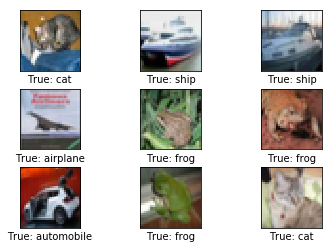

In [11]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above are what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

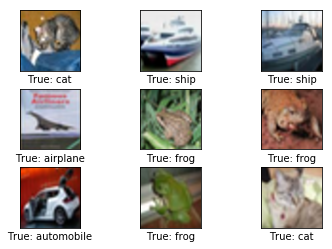

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

# AlexNet

In [13]:
def conv_layer(input, layin_cnt, filter_size, layout_cnt, strides, name):
    shape = [filter_size, filter_size, layin_cnt, layout_cnt]
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05), trainable=True, name="w_" + name)
    baises = tf.Variable(tf.truncated_normal(shape=[layout_cnt], stddev=0.05), name="b_" + name)
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=strides, padding='SAME')
    
    layer += baises
    return layer
    

In [14]:
def fc_layer(input, in_cnt, out_cnt, name):
    weights = tf.Variable(tf.truncated_normal([in_cnt, out_cnt], stddev=0.05), trainable=True, name = "w_" + name)
    baises = tf.Variable(tf.truncated_normal(shape=[out_cnt], stddev=0.05), name = "b_" + name)
        
    layer = tf.matmul(input, weights) + baises
    
    return layer

In [15]:
def flatten_layer(layer, name):
    shape = layer.get_shape()
    feat_cnt = shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, feat_cnt])
    return layer_flat, feat_cnt

In [16]:
def pre_process_image(image, training):
    if training:
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,                                                       target_height=img_size_cropped,
                                                   target_width=img_size_cropped)
    return image
    
def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    return images

In [17]:
class AlexNet:
    def __init__(self, save_path):
        self.train_batch_size = 64
        self.save_path = save_path
        
    
    def _create_placeholder(self):
        with tf.name_scope("data"):
            self.im = tf.placeholder(tf.float32, shape=[None, 32, 32, num_channels], name='x')
            self.y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
            self.y_true_cls = tf.argmax(self.y_true, dimension=1)
            self.global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)
            
    
    def _create_layer1(self):
        with tf.name_scope("layer1"):
            conv1_1 = conv_layer(self.x, num_channels, 11, 48, [1, 4, 4, 1], "conv1_1")
            self.conv1_1 = tf.nn.relu(conv1_1)
            conv2_1 = conv_layer(self.x, num_channels, 11, 48, [1, 4, 4, 1], "conv2_1")
            self.conv2_1 = tf.nn.relu(conv2_1)
          
    def _create_layer2(self):
        with tf.name_scope("layer2"):
            pool1_2 = tf.nn.max_pool(value=self.conv1_1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding = 'SAME')
            pool2_2 = tf.nn.max_pool(value=self.conv2_1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding = 'SAME')
            conv1_2 = conv_layer(pool1_2, 48, 5, 128, [1, 1, 1, 1], "conv1_2")
            self.conv1_2 = tf.nn.relu(conv1_2)
            conv2_2 = conv_layer(pool2_2, 48, 5, 128, [1, 1, 1, 1], "conv2_2")
            self.conv2_2 = tf.nn.relu(conv2_2)
    
    def _create_layer3(self):
        with tf.name_scope("layer3"):
            pool1_3 = tf.nn.max_pool(value=self.conv1_2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding = 'SAME')
            pool2_3 = tf.nn.max_pool(value=self.conv2_2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding = 'SAME')
        
            conv1_3 = tf.add(conv_layer(pool1_3, 128, 3, 192, [1, 1, 1, 1], "conv1_3"),
                          conv_layer(pool2_3, 128, 3, 192, [1, 1, 1, 1], "conv1_3"))
            self.conv1_3 = tf.nn.relu(conv1_3)
            conv2_3 = tf.add(conv_layer(pool1_3, 128, 3, 192, [1, 1, 1, 1], "conv2_3"),
                          conv_layer(pool2_3, 128, 3, 192, [1, 1, 1, 1], "conv1_2"))
            self.conv2_3 = tf.nn.relu(conv2_3)
        
    def _create_layer4(self):
        with tf.name_scope("layer4"):
            conv1_4 = conv_layer(self.conv1_3, 192, 3, 192, [1, 1, 1, 1], "conv1_4")
            self.conv1_4 = tf.nn.relu(conv1_4)
            conv2_4 = conv_layer(self.conv2_3, 192, 3, 192, [1, 1, 1, 1], "conv2_4")
            self.conv2_4 = tf.nn.relu(conv2_4)
            
    def _create_layer5(self):
        with tf.name_scope("layer5"):
            conv1_5 = conv_layer(self.conv1_4, 192, 3, 128, [1, 1, 1, 1], "conv1_5")
            conv1_5 = tf.nn.relu(conv1_5)
            conv2_5 = conv_layer(self.conv2_4, 192, 3, 128, [1, 1, 1, 1], "conv2_5")
            conv2_5 = tf.nn.relu(conv2_5)
        
            self.pool1_5 = tf.nn.max_pool(value=conv1_5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding = 'SAME')
            self.pool2_5 = tf.nn.max_pool(value=conv2_5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding = 'SAME')
        
    def _create_layer6(self):
        with tf.name_scope("layer6"):
            flat1_6, fcnt1_6 = flatten_layer(self.pool1_5, "flat1_6")
            flat2_6, fcnt2_6 = flatten_layer(self.pool2_5, "flat2_6")    
            
            fc1_6 = tf.add(fc_layer(flat1_6, fcnt1_6, 2048, "fc1_6"),
                       fc_layer(flat2_6, fcnt2_6, 2048, "fc2_6"))
            self.fc1_6 = tf.nn.relu(fc1_6)
            fc2_6 = tf.add(fc_layer(flat1_6, fcnt1_6, 2048, "fc2_6"),
                       fc_layer(flat2_6, fcnt2_6, 2048, "fc2_6"))
            self.fc2_6 = tf.nn.relu(fc2_6)
        
    def _create_layer7(self):
        with tf.name_scope("layer7"):
            fc1_7 = tf.add(fc_layer(self.fc1_6, 2048, 2048, "fc1_7"),
                       fc_layer(self.fc2_6, 2048, 2048, "fc1_7"))
            self.fc1_7 = tf.nn.relu(fc1_7)
            fc2_7 = tf.add(fc_layer(self.fc1_6, 2048, 2048, "fc2_7"),
                       fc_layer(self.fc2_6, 2048, 2048, "fc2_7"))
            self.fc2_7 = tf.nn.relu(fc2_7)
            
        
    def build_graph(self):
        self._create_placeholder()
        self.x = pre_process(images=self.im, training=True)
        self._create_layer1()
        self._create_layer2()
        self._create_layer3()
        self._create_layer4()
        self._create_layer5()
        self._create_layer6()
        self._create_layer7()
        
        fc8 = tf.add(fc_layer(self.fc1_7, 2048, num_classes, "fc8"),
                     fc_layer(self.fc2_7, 2048, num_classes, "fc8"))
        
        y_pred = tf.nn.softmax(fc8)
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc8, labels=self.y_true)
        cost = tf.reduce_mean(cross_entropy)
        
        self.y_pred_cls = tf.argmax(y_pred, dimension=1)
        
        correct_prediction = tf.equal(self.y_pred_cls, self.y_true_cls)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost, global_step=self.global_step)
        
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.saver = tf.train.Saver()
        return
        
        
    def random_batch(self, images_train, labels_train):
        num_images = len(images_train)
        idx = np.random.choice(num_images,
                           size=self.train_batch_size,
                           replace=False)
        x_batch = images_train[idx, :, :, :]
        y_batch = labels_train[idx, :]
        return x_batch, y_batch
        
    def train_model(self, images, y_true, num_iterations):
        start_time = time.time()

        for i in range(num_iterations):
            x_batch, y_true_batch = self.random_batch(images, y_true)
            
            feed_dict_train = {self.im: x_batch, self.y_true: y_true_batch}

            i_global, _ = session.run([self.global_step, self.optimizer],
                                  feed_dict=feed_dict_train)

            if (i_global % 100 == 0) or (i == num_iterations - 1):
                batch_acc = session.run(self.accuracy, feed_dict=feed_dict_train)

                msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
                print(msg.format(i_global, batch_acc))

            if (i_global % 1000 == 0) or (i == num_iterations - 1):
                self.saver.save(session,
                       save_path=save_path,
                       global_step=self.global_step)

                print("Saved checkpoint.")
        
        end_time = time.time()
        time_dif = end_time - start_time
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        return
    
    
    def predict_cls(self, images, labels, cls_true):
        batch_size = 256
        num_images = len(images)
        
        cls_pred = np.zeros(shape=num_images, dtype=np.int)
        i = 0
        
        while i < num_images:
            j = min(i + batch_size, num_images)
            feed_dict = {self.im: images[i:j, :],
                     self.y_true: labels[i:j, :]}
            cls_pred[i:j] = session.run(self.y_pred_cls, feed_dict=feed_dict)
            i = j

        correct = (cls_true == cls_pred)

        return correct, cls_pred
        

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [18]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
distorted_images = pre_process(images=x, training=True)

### Getting the Weights

Further below, we want to plot the weights of the neural network. When the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `layer_conv1` and `layer_conv2` for the two convolutional layers. These are also called variable scopes. Pretty Tensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [19]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [20]:
session = tf.Session()

### Restore or initialize variables

Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If you want to restart the training of the neural network, you have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [21]:
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [22]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TensorFlow will append the iteration number, etc.

In [23]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [24]:
an = AlexNet(save_path)
an.build_graph()

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TensorFlow graph.

In [25]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    an.saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from None
Failed to restore checkpoint. Initializing variables instead.


### Plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [26]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Plot confusion matrix

In [27]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

Calculate the predicted class for the test-set.

In [28]:
def predict_cls_test():
    return an.predict_cls(images = images_test, labels = labels_test, cls_true = cls_test)

### Helper-functions for the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [29]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [30]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Examples of distorted input images

In order to artificially inflate the number of images available for training, the neural network uses pre-processing with random distortions of the input images. This should hopefully make the neural network more flexible at recognizing and classifying images.

This is a helper-function for plotting distorted input images.

In [31]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

Helper-function for getting an image and its class-number from the test-set.

In [32]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

Get an image and its true class from the test-set.

In [33]:
img, cls = get_test_image(16)

Plot 9 random distortions of the image. If you re-run this code you will get slightly different results.

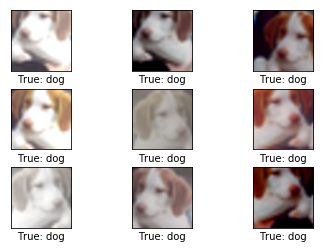

In [34]:
plot_distorted_image(img, cls)

## Perform optimization

In [38]:
an.train_model(images_train, labels_train, num_iterations=100000)

Global Step:   1100, Training Batch Accuracy:  28.1%
Global Step:   1200, Training Batch Accuracy:  35.9%
Global Step:   1300, Training Batch Accuracy:  31.2%
Global Step:   1400, Training Batch Accuracy:  43.8%
Global Step:   1500, Training Batch Accuracy:  29.7%
Global Step:   1600, Training Batch Accuracy:  35.9%
Global Step:   1700, Training Batch Accuracy:  40.6%
Global Step:   1800, Training Batch Accuracy:  23.4%
Global Step:   1900, Training Batch Accuracy:  40.6%
Global Step:   2000, Training Batch Accuracy:  34.4%
Saved checkpoint.
Global Step:   2100, Training Batch Accuracy:  35.9%
Global Step:   2200, Training Batch Accuracy:  42.2%
Global Step:   2300, Training Batch Accuracy:  43.8%
Global Step:   2400, Training Batch Accuracy:  46.9%
Global Step:   2500, Training Batch Accuracy:  37.5%
Global Step:   2600, Training Batch Accuracy:  45.3%
Global Step:   2700, Training Batch Accuracy:  40.6%
Global Step:   2800, Training Batch Accuracy:  37.5%
Global Step:   2900, Trainin

Saved checkpoint.
Global Step:  16100, Training Batch Accuracy:  50.0%
Global Step:  16200, Training Batch Accuracy:  56.2%
Global Step:  16300, Training Batch Accuracy:  43.8%
Global Step:  16400, Training Batch Accuracy:  59.4%
Global Step:  16500, Training Batch Accuracy:  50.0%
Global Step:  16600, Training Batch Accuracy:  50.0%
Global Step:  16700, Training Batch Accuracy:  42.2%
Global Step:  16800, Training Batch Accuracy:  56.2%
Global Step:  16900, Training Batch Accuracy:  53.1%
Global Step:  17000, Training Batch Accuracy:  62.5%
Saved checkpoint.
Global Step:  17100, Training Batch Accuracy:  56.2%
Global Step:  17200, Training Batch Accuracy:  46.9%
Global Step:  17300, Training Batch Accuracy:  40.6%
Global Step:  17400, Training Batch Accuracy:  43.8%
Global Step:  17500, Training Batch Accuracy:  48.4%
Global Step:  17600, Training Batch Accuracy:  40.6%
Global Step:  17700, Training Batch Accuracy:  54.7%
Global Step:  17800, Training Batch Accuracy:  57.8%
Global Ste

Saved checkpoint.
Global Step:  31100, Training Batch Accuracy:  62.5%
Global Step:  31200, Training Batch Accuracy:  65.6%
Global Step:  31300, Training Batch Accuracy:  65.6%
Global Step:  31400, Training Batch Accuracy:  59.4%
Global Step:  31500, Training Batch Accuracy:  59.4%
Global Step:  31600, Training Batch Accuracy:  50.0%
Global Step:  31700, Training Batch Accuracy:  62.5%
Global Step:  31800, Training Batch Accuracy:  56.2%
Global Step:  31900, Training Batch Accuracy:  50.0%
Global Step:  32000, Training Batch Accuracy:  56.2%
Saved checkpoint.
Global Step:  32100, Training Batch Accuracy:  46.9%
Global Step:  32200, Training Batch Accuracy:  59.4%
Global Step:  32300, Training Batch Accuracy:  62.5%
Global Step:  32400, Training Batch Accuracy:  65.6%
Global Step:  32500, Training Batch Accuracy:  53.1%
Global Step:  32600, Training Batch Accuracy:  62.5%
Global Step:  32700, Training Batch Accuracy:  64.1%
Global Step:  32800, Training Batch Accuracy:  64.1%
Global Ste

Saved checkpoint.
Global Step:  46100, Training Batch Accuracy:  59.4%
Global Step:  46200, Training Batch Accuracy:  65.6%
Global Step:  46300, Training Batch Accuracy:  65.6%
Global Step:  46400, Training Batch Accuracy:  64.1%
Global Step:  46500, Training Batch Accuracy:  59.4%
Global Step:  46600, Training Batch Accuracy:  59.4%
Global Step:  46700, Training Batch Accuracy:  57.8%
Global Step:  46800, Training Batch Accuracy:  56.2%
Global Step:  46900, Training Batch Accuracy:  68.8%
Global Step:  47000, Training Batch Accuracy:  51.6%
Saved checkpoint.
Global Step:  47100, Training Batch Accuracy:  57.8%
Global Step:  47200, Training Batch Accuracy:  65.6%
Global Step:  47300, Training Batch Accuracy:  50.0%
Global Step:  47400, Training Batch Accuracy:  67.2%
Global Step:  47500, Training Batch Accuracy:  70.3%
Global Step:  47600, Training Batch Accuracy:  50.0%
Global Step:  47700, Training Batch Accuracy:  59.4%
Global Step:  47800, Training Batch Accuracy:  59.4%
Global Ste

Saved checkpoint.
Global Step:  61100, Training Batch Accuracy:  68.8%
Global Step:  61200, Training Batch Accuracy:  60.9%
Global Step:  61300, Training Batch Accuracy:  60.9%
Global Step:  61400, Training Batch Accuracy:  68.8%
Global Step:  61500, Training Batch Accuracy:  67.2%
Global Step:  61600, Training Batch Accuracy:  71.9%
Global Step:  61700, Training Batch Accuracy:  62.5%
Global Step:  61800, Training Batch Accuracy:  76.6%
Global Step:  61900, Training Batch Accuracy:  71.9%
Global Step:  62000, Training Batch Accuracy:  68.8%
Saved checkpoint.
Global Step:  62100, Training Batch Accuracy:  68.8%
Global Step:  62200, Training Batch Accuracy:  62.5%
Global Step:  62300, Training Batch Accuracy:  65.6%
Global Step:  62400, Training Batch Accuracy:  70.3%
Global Step:  62500, Training Batch Accuracy:  64.1%
Global Step:  62600, Training Batch Accuracy:  53.1%
Global Step:  62700, Training Batch Accuracy:  73.4%
Global Step:  62800, Training Batch Accuracy:  68.8%
Global Ste

Saved checkpoint.
Global Step:  76100, Training Batch Accuracy:  76.6%
Global Step:  76200, Training Batch Accuracy:  78.1%
Global Step:  76300, Training Batch Accuracy:  70.3%
Global Step:  76400, Training Batch Accuracy:  73.4%
Global Step:  76500, Training Batch Accuracy:  67.2%
Global Step:  76600, Training Batch Accuracy:  73.4%
Global Step:  76700, Training Batch Accuracy:  62.5%
Global Step:  76800, Training Batch Accuracy:  68.8%
Global Step:  76900, Training Batch Accuracy:  71.9%
Global Step:  77000, Training Batch Accuracy:  71.9%
Saved checkpoint.
Global Step:  77100, Training Batch Accuracy:  67.2%
Global Step:  77200, Training Batch Accuracy:  71.9%
Global Step:  77300, Training Batch Accuracy:  75.0%
Global Step:  77400, Training Batch Accuracy:  70.3%
Global Step:  77500, Training Batch Accuracy:  68.8%
Global Step:  77600, Training Batch Accuracy:  68.8%
Global Step:  77700, Training Batch Accuracy:  67.2%
Global Step:  77800, Training Batch Accuracy:  70.3%
Global Ste

Saved checkpoint.
Global Step:  91100, Training Batch Accuracy:  71.9%
Global Step:  91200, Training Batch Accuracy:  70.3%
Global Step:  91300, Training Batch Accuracy:  75.0%
Global Step:  91400, Training Batch Accuracy:  71.9%
Global Step:  91500, Training Batch Accuracy:  82.8%
Global Step:  91600, Training Batch Accuracy:  76.6%
Global Step:  91700, Training Batch Accuracy:  68.8%
Global Step:  91800, Training Batch Accuracy:  67.2%
Global Step:  91900, Training Batch Accuracy:  81.2%
Global Step:  92000, Training Batch Accuracy:  65.6%
Saved checkpoint.
Global Step:  92100, Training Batch Accuracy:  71.9%
Global Step:  92200, Training Batch Accuracy:  67.2%
Global Step:  92300, Training Batch Accuracy:  73.4%
Global Step:  92400, Training Batch Accuracy:  76.6%
Global Step:  92500, Training Batch Accuracy:  79.7%
Global Step:  92600, Training Batch Accuracy:  67.2%
Global Step:  92700, Training Batch Accuracy:  70.3%
Global Step:  92800, Training Batch Accuracy:  59.4%
Global Ste

## Results

Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

Accuracy on Test-Set: 63.1% (6313 / 10000)
Example errors:


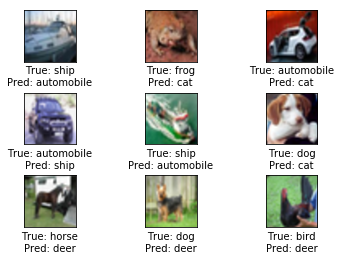

Confusion Matrix:
[728  18  45  25  28  10  10  18  88  30] (0) airplane
[ 34 725  23  30  10  17  16   8  56  81] (1) automobile
[ 81   6 534  86  85  58  78  43  17  12] (2) bird
[ 31  12  71 494  58 151  76  69  16  22] (3) cat
[ 34   8 102  76 522  37  67 125  15  14] (4) deer
[ 16   7  63 223  55 489  43  85   9  10] (5) dog
[ 20  12  52  79  45  44 717  18   6   7] (6) frog
[ 22   3  29  55  62  70  23 713   3  20] (7) horse
[ 76  37  21  23  14   7   6   9 768  39] (8) ship
[ 45 112  28  42  11  30  21  32  56 623] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [39]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [37]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Homework

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Run the optimization for 100,000 iterations and see what the classification accuracy is. This will create a checkpoint that saves all the variables of the TensorFlow graph.
* Try changing the structure of the neural network to AlexNet. How does it affect the training time and the classification accuracy? Note that the checkpoints cannot be reloaded when you change the structure of the neural network.